<a href="https://colab.research.google.com/github/anhle/Kaggle/blob/master/predicting_pathologies_in_x_ray_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Pathologies In X-Ray Images**  *--work in progress--*

The NIH Clinical Center recently released over 100,000 anonymized chest x-ray images and their corresponding data to the scientific community. The release will allow researchers across the country and around the world to freely access the datasets and increase their ability to teach computers how to detect and diagnose disease. Ultimately, this artificial intelligence mechanism can lead to clinicians making better diagnostic decisions for patients.   

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

https://stanfordmlgroup.github.io/projects/chexnet/

In [1]:

import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.


In [34]:
!pip install -U -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [40]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d kmader/full-keras-pretrained-no-top

 99% 0.99G/1.00G [00:15<00:00, 71.1MB/s]
100% 1.00G/1.00G [00:15<00:00, 69.2MB/s]


In [50]:
!unzip full-keras-pretrained-no-top.zip

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
unzip:  cannot find or open full-keras-pretrained-no-top.zip, full-keras-pretrained-no-top.zip.zip or full-keras-pretrained-no-top.zip.ZIP.


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [0]:
os.chdir('drive/My Drive/data/chestxray')

In [3]:
!pwd

/content/drive/My Drive/data/chestxray


Load the data

In [0]:

PATH = '.'
SOURCE_IMAGES = os.path.join(PATH, images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))
print(PATH)
images[0:10]

In [7]:
labels = pd.read_csv('./sample/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


Plot a representative image

It should be noted that these images require some significant pre-processing and/or relabeling for best results.  For this exercise we will do only minimal pre-processing of the images.  See the following blogpost for more detail about specific challenges associated with this dataset: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

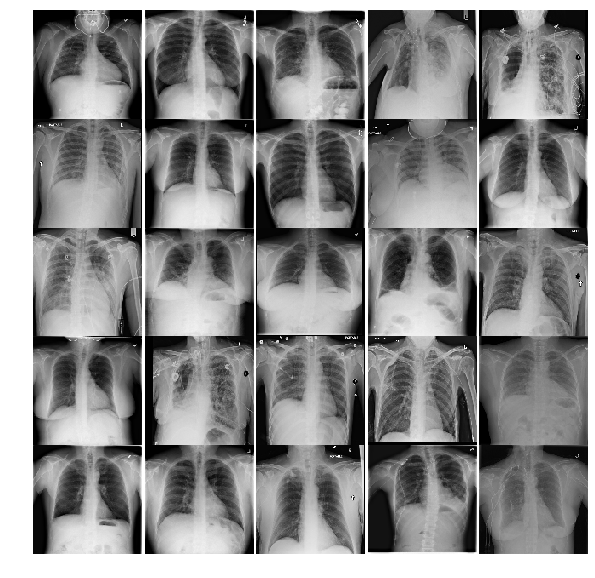

In [8]:
multipleImages = glob('sample/sample/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

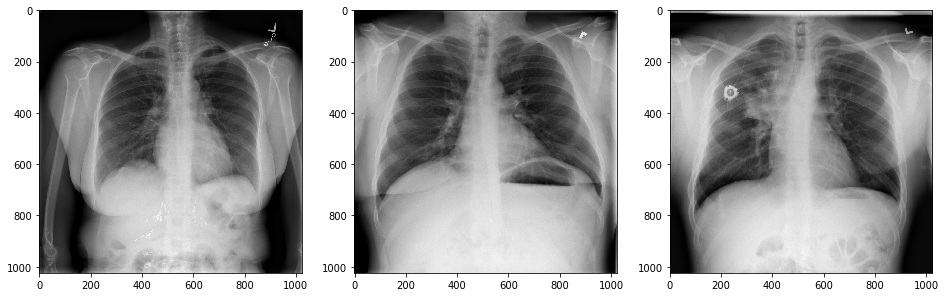

In [11]:
r = random.sample(images, 3)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

What types of ailments are identified in these annotated X-ray images?

In [9]:
labels = pd.read_csv('sample/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


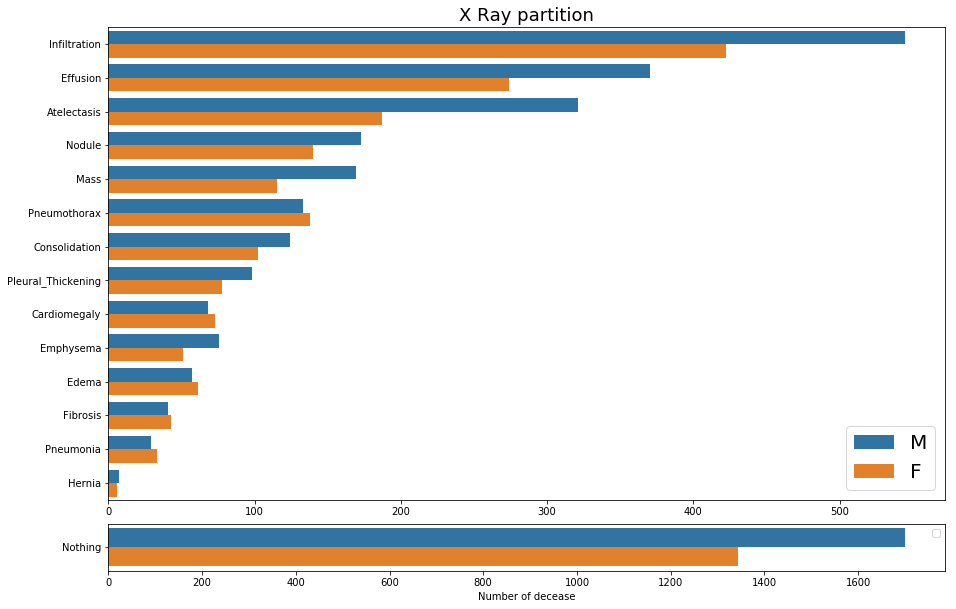

In [10]:
#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

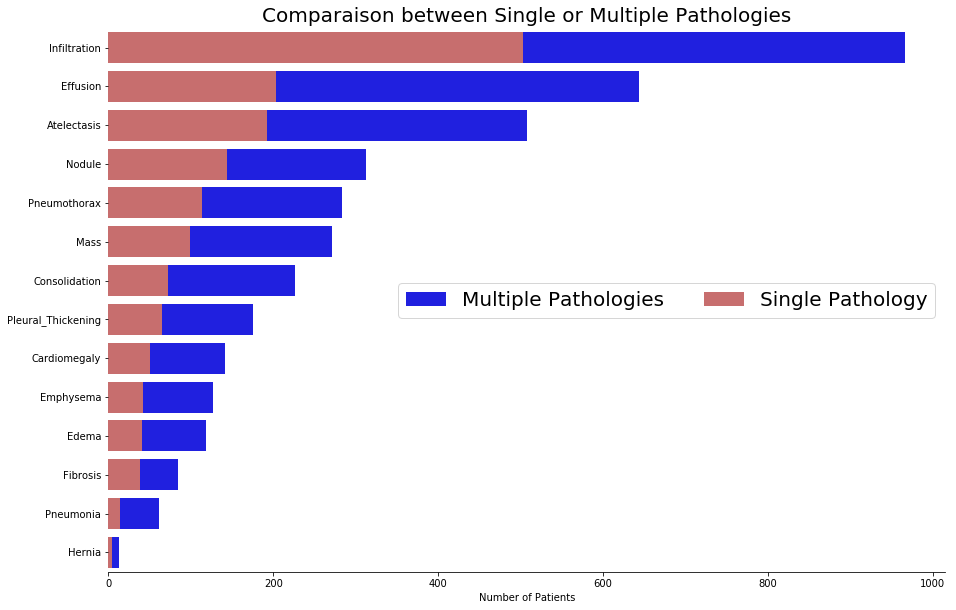

In [11]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="r",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=20)      
sns.despine(left=True)

Convert annotated .png images into labeled numpy arrays.  Discard all images with more than one pathology.

In [0]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [0]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 7
    Emphysema="Emphysema" #7
    Fibrosis="Fibrosis" #7
    Effusion="Effusion" #4
    Pneumonia="Pneumonia" #7
    Pleural_Thickening="Pleural_Thickening" #7
    Cardiomegaly="Cardiomegaly" #7
    NoduleMass="Nodule" #5
    Hernia="Hernia" #7
    Atelectasis="Atelectasis"  #6 
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 128
    HEIGHT = 128
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if symbol in finding:
            continue
        else:
            if NoFinding in finding:
                finding = 0
                #y.append(finding)
                #x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Consolidation in finding:
                finding = 1
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Edema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Emphysema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Fibrosis in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in finding:
                finding = 4
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumonia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pleural_Thickening in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Cardiomegaly in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoduleMass in finding:
                finding = 5
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Hernia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Atelectasis in finding:
                finding = 6
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

In [14]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

1483 (128, 128, 3)
<class 'list'>


Describe new numpy arrays

In [15]:
dict_characters = {1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4:'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: "Other Rare Classes"}

print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       7
1  [[[250, 250, 250], [148, 148, 148], [93, 93, 9...       7
2  [[[68, 68, 68], [44, 44, 44], [24, 24, 24], [1...       3
3  [[[7, 7, 7], [6, 6, 6], [6, 6, 6], [6, 6, 6], ...       7
4  [[[10, 10, 10], [10, 10, 10], [10, 10, 10], [1...       7
5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       1
6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       3
7  [[[0, 0, 0], [19, 19, 19], [20, 20, 20], [20, ...       7
8  [[[16, 16, 16], [1, 1, 1], [1, 1, 1], [0, 0, 0...       2
9  [[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...       5

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


Describe the distribution of pixel intensities within a representative image

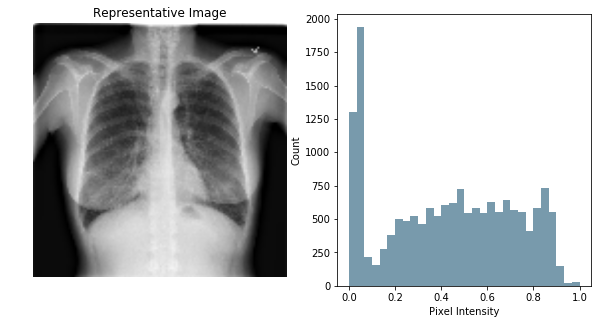

In [17]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[1])

Normalize the pixel intensities between zero and one.

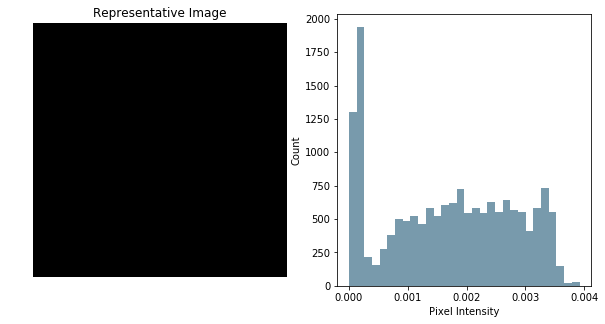

In [18]:
X=np.array(X)
X=X/255.0
plotHistogram(X[1])

Describe distribution of class labels

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


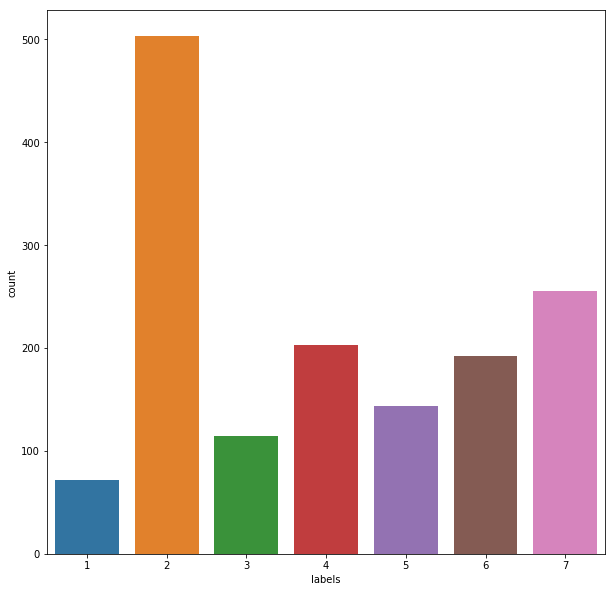

In [19]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#print(dist)

We have imbalanced sample sizes.  This is a problem that needs to be addressed.

But for now we can proceed with a preliminary analysis.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [21]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (1186, 128, 128, 3)
Testing Data Shape: (297, 128, 128, 3)
Training Data Shape: 1186 (128, 128, 3)
Testing Data Shape: 297 (128, 128, 3)


Now I will try to use a CNN to predict each ailment based off of the X-Ray image.

In [0]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 8)
Y_testHot = to_categorical(Y_test, num_classes = 8)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes.  In this case the class_weights parameter will eventually be passed to the model.fit function.

In [23]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[2.94246032 0.42118716 1.85839599 1.04363125 1.47123016 1.10342262
 0.83081232]


In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Epoch 1/50
38/37 [==============================] - 9s 229ms/step - loss: 10.6756 - acc: 0.3111 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 2/50
38/37 [==============================] - 7s 173ms/step - loss: 10.6322 - acc: 0.3404 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 3/50
38/37 [==============================] - 7s 179ms/step - loss: 10.6322 - acc: 0.3404 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 4/50
38/37 [==============================] - 7s 182ms/step - loss: 10.8259 - acc: 0.3283 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 5/50
38/37 [==============================] - 7s 184ms/step - loss: 10.8259 - acc: 0.3283 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 6/50
38/37 [==============================] - 7s 178ms/step - loss: 10.6322 - acc: 0.3404 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 7/50
38/37 [==============================] - 7s 180ms/step - loss: 10.6322 - acc: 0.3404 - val_loss: 10.4740 - val_acc: 0.3502
Epoch 8/50
38/37 [==============================] - 7s 180ms/s

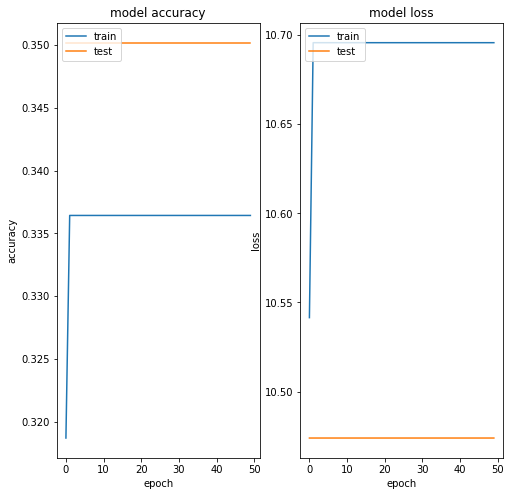

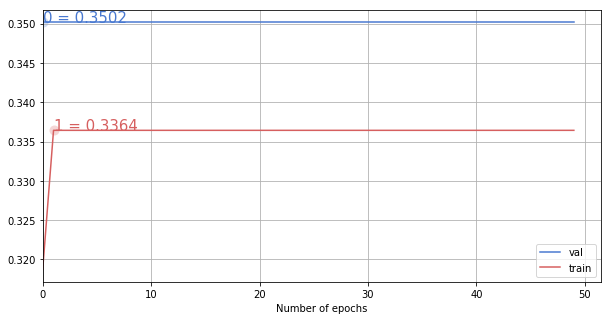


Keras CNN #2B - accuracy: 0.3501683502686947 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        14
      Infiltration       0.35      1.00      0.52       104
      Pneumothorax       0.00      0.00      0.00        24
          Effusion       0.00      0.00      0.00        48
       Nodule Mass       0.00      0.00      0.00        25
       Atelectasis       0.00      0.00      0.00        35
Other Rare Classes       0.00      0.00      0.00        47

          accuracy                           0.35       297
         macro avg       0.05      0.14      0.07       297
      weighted avg       0.12      0.35      0.18       297



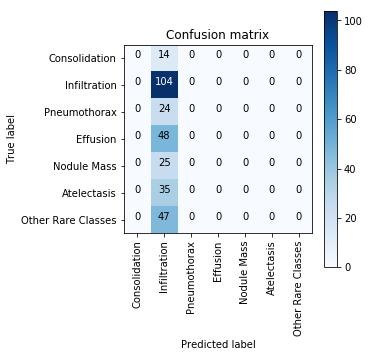

In [39]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,50,1)
# restore np.load for future normal usage
np.load = np_load_old

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        14
      Infiltration       0.35      1.00      0.52       104
      Pneumothorax       0.00      0.00      0.00        24
          Effusion       0.00      0.00      0.00        48
       Nodule Mass       0.00      0.00      0.00        25
       Atelectasis       0.00      0.00      0.00        35
Other Rare Classes       0.00      0.00      0.00        47

          accuracy                           0.35       297
         macro avg       0.05      0.14      0.07       297
      weighted avg       0.12      0.35      0.18       297



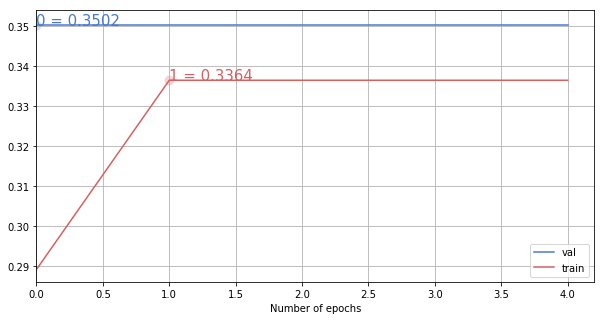

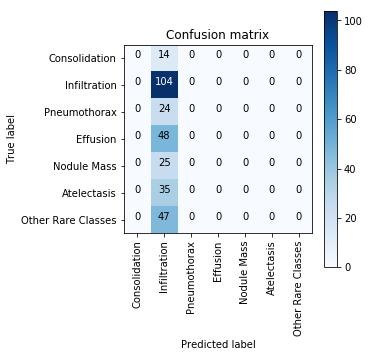

In [26]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 128
map_characters=dict_characters

import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(#weights='imagenet',
        weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,5)
# restore np.load for future normal usage
np.load = np_load_old

The imbalance in our dataset has resulted in a biased model.  I tried to prevent this by modifying the class_weights parameter and using in the model.fit function but apparently that was not enough.  Now I will try to compensate for the imbalanced sample size by oversampling or upsampling the minority classes.

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


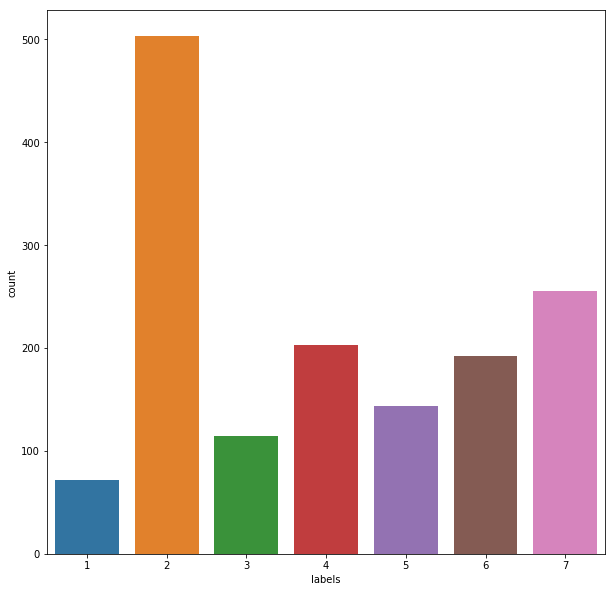

In [28]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

It is very import to do upsampling AFTER the train_test_split function otherwise you can end up with values in the testing dataset that are related to the values within the training dataset.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [30]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (1186, 128, 128, 3)
X_test Shape:  (297, 128, 128, 3)
X_trainFlat Shape:  (1186, 49152)
X_testFlat Shape:  (297, 49152)


In [31]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 8)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 8)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


X_train:  (1186, 128, 128, 3)
X_trainFlat:  (1186, 49152)
X_trainRos Shape:  (2877, 49152)
X_testRos Shape:  (644, 49152)
Y_trainRosHot Shape:  (2877, 8)
Y_testRosHot Shape:  (644, 8)


In [32]:
for i in range(len(X_trainRos)):
    height, width, channels = 128,128,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 128,128,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (2877, 49152)
X_trainRosReshaped Shape:  (2877, 128, 128, 3)
X_testRos Shape:  (644, 49152)
X_testRosReshaped Shape:  (644, 128, 128, 3)


{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


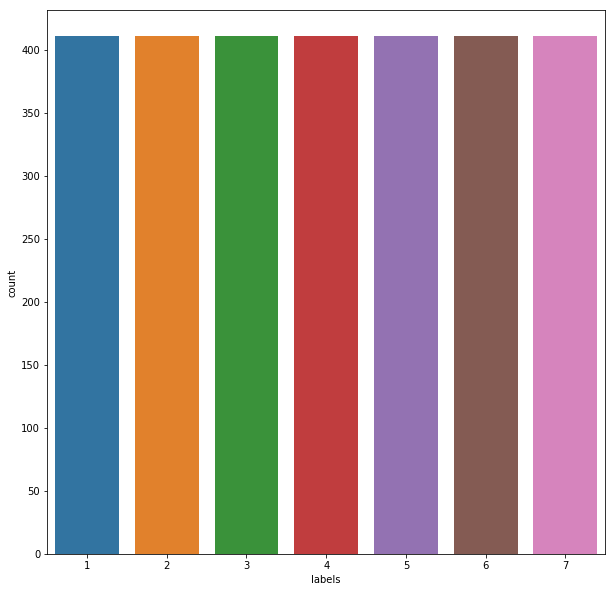

In [33]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

Now we have a much more even distriution of sample sizes for each of our 7 ailments (plus an 8th category for other/typos).  This should help make our model less biased in favor of the majority class (0=No Finding).

In [40]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [2.94246032 0.42118716 1.85839599 1.04363125 1.47123016 1.10342262
 0.83081232]
New Class Weights:  [1. 1. 1. 1. 1. 1. 1.]


Epoch 1/10
90/89 [==============================] - 19s 213ms/step - loss: 13.4540 - acc: 0.1486 - val_loss: 14.1740 - val_acc: 0.1102
Epoch 2/10
90/89 [==============================] - 17s 184ms/step - loss: 13.6843 - acc: 0.1459 - val_loss: 13.2853 - val_acc: 0.1739
Epoch 3/10
90/89 [==============================] - 17s 185ms/step - loss: 13.7370 - acc: 0.1435 - val_loss: 14.0908 - val_acc: 0.1258
Epoch 4/10
90/89 [==============================] - 17s 186ms/step - loss: 13.7023 - acc: 0.1463 - val_loss: 13.9017 - val_acc: 0.1351
Epoch 5/10
90/89 [==============================] - 17s 186ms/step - loss: 13.6037 - acc: 0.1533 - val_loss: 14.3226 - val_acc: 0.1102
Epoch 6/10
90/89 [==============================] - 17s 188ms/step - loss: 13.6745 - acc: 0.1487 - val_loss: 13.8155 - val_acc: 0.1429
Epoch 7/10
90/89 [==============================] - 17s 187ms/step - loss: 13.8222 - acc: 0.1366 - val_loss: 13.8906 - val_acc: 0.1382
Epoch 8/10
90/89 [==============================] - 17s

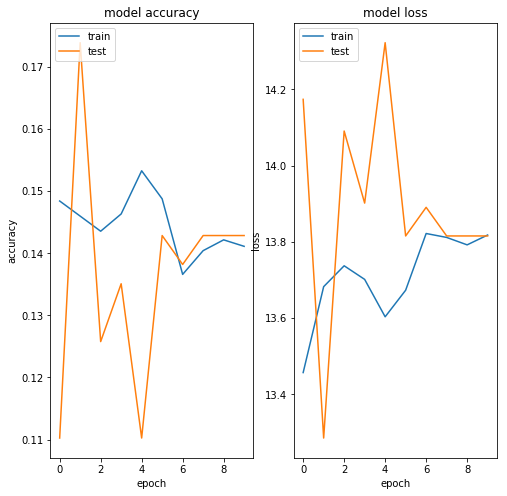

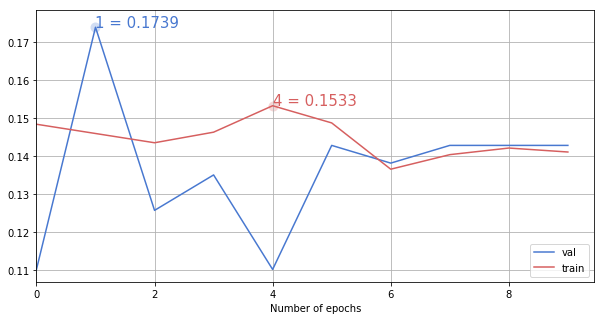


Keras CNN #2B - accuracy: 0.14285714285714285 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        92
      Infiltration       0.00      0.00      0.00        92
      Pneumothorax       0.00      0.00      0.00        92
          Effusion       0.14      1.00      0.25        92
       Nodule Mass       0.00      0.00      0.00        92
       Atelectasis       0.00      0.00      0.00        92
Other Rare Classes       0.00      0.00      0.00        92

          accuracy                           0.14       644
         macro avg       0.02      0.14      0.04       644
      weighted avg       0.02      0.14      0.04       644



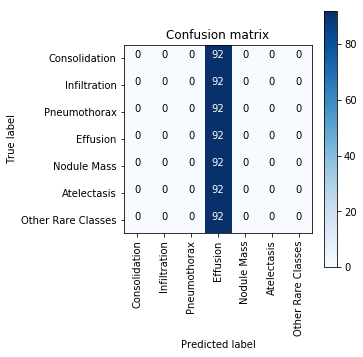

In [41]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

runCNNconfusion(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,8,10,1)

# restore np.load for future normal usage
np.load = np_load_old


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        92
      Infiltration       0.00      0.00      0.00        92
      Pneumothorax       0.00      0.00      0.00        92
          Effusion       0.14      1.00      0.25        92
       Nodule Mass       0.00      0.00      0.00        92
       Atelectasis       0.00      0.00      0.00        92
Other Rare Classes       0.00      0.00      0.00        92

          accuracy                           0.14       644
         macro avg       0.02      0.14      0.04       644
      weighted avg       0.02      0.14      0.04       644



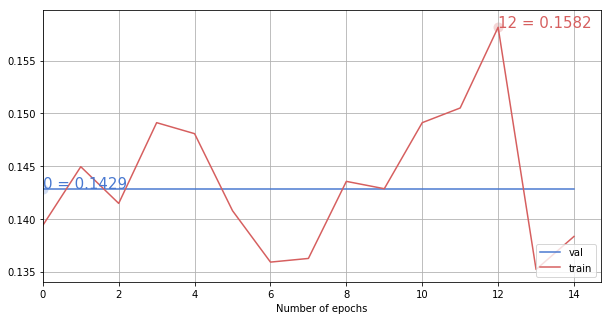

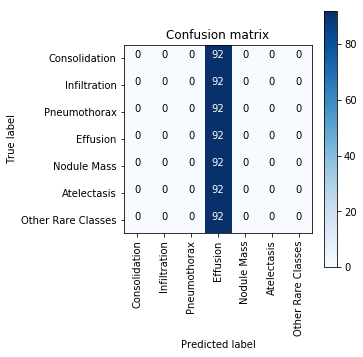

In [38]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
vgg16network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,8,15)
# restore np.load for future normal usage
np.load = np_load_old

Our model can predict pathologies in x-ray images with an accuracy rate that is much better than random chance but there is still a lot of room for improvement.  Please see the [following blogpost](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/) for more detail about specific challenges associated with this dataset . 